In [189]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import plotly.express as px
from scipy.optimize import curve_fit
import math
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error
import ruptures as rpt
import warnings
warnings.simplefilter('ignore')
import sys
sys.path.insert(0,'/Users/Kathy/Desktop/UW/seaflow/decomposition_project/scripts/')
from diel_tools import *
from fig_tools import *
from tsd_functions import *
from rate_functions import *
from simulation_tools import *

## Plot Annette's model's growth rate and productivity

In [190]:
# helper function to assign cruise days to dates
def cruise_dates_to_days(df, dates, days):
    # loop and assign
    for date,day in zip(dates,days):
        # assign cruise day based on date
        df.loc[df['date']==date, 'cruise_day']=day
    return df

In [431]:
## look annette's data from her model
annette_df=pd.read_csv('data/SeaFlow_ALOHA_growth_productivity.csv')
# filter out crocosphaera
annette_df=annette_df.loc[annette_df['pop']!='croco']
# rename euks
annette_df.loc[annette_df['pop']=='euk', 'pop']='picoeuk'
dfs=[]
# set crusie days for each data
for cruise in pd.unique(annette_df['cruise']):
    # get subdf of cruise
    sub_df=annette_df.loc[annette_df['cruise']==cruise]
    cruise_dates=pd.unique(sub_df['date'])
    # generate cruise days based on number of dates
    cruise_days=np.char.mod('%d', np.arange(1,len(cruise_dates)+1))
    # assign cruise days to dates
    dfs.append(cruise_dates_to_days(annette_df.loc[annette_df['cruise']==cruise], 
                               cruise_dates, cruise_days))
days_df=pd.concat(dfs)

# # calculate daily growth by daylength and r
# days_df['daily_growth']=days_df['daylength']*days_df['r']
# # estimate with error
# days_df['daily_se']=days_df['daylength']*days_df['r_se']

## Plot TSD estimates of growth rate and productivity
1. Check for missing data
    - Yes, run imputation.
    - No, move to step 2.
2. Check for data length.
    - <3, select Rolling Model.
    - ≥3, select STL Model.
3. Run selected TSD model.
4. Calculate diel growth by exponential cellular growth function.
5. Check for stationarity.
    - Yes, calculate mean trend across time series.
    - No, calculate breakpoints and mean trend per break point.
6. Calculate net productivity by growth and mean trend across dataset of breakpoints.

In [4]:
# load the data
all_cruises = pd.read_csv('/Users/Kathy/Desktop/UW/diel_workshop/PSD_mean_2022-10-20.csv')
all_cruises.rename(columns={'date':'time', 'c_quotas':'Qc_hour'}, inplace=True)
all_cruises = all_cruises.loc[((all_cruises['pop'] == 'prochloro')) | (all_cruises['pop']== 'synecho')]
all_cruises['time'] = pd.DatetimeIndex(all_cruises['time'].apply(lambda x: parse(x))).tz_convert('UTC')
# read in instrument log
log=pd.read_csv('data/seaflow_log.csv')
# grab only g1 data
cruise_daily=all_cruises.loc[all_cruises['cruise']=='SCOPE_16']
# grab cruises from annette's model
hot_ids=pd.unique(annette_df['cruise'])
hot_names=log.loc[log['Cruise ID'].isin(hot_ids),'cruise'].values
# grab names that correspond to cruise ID
hot_cruises=all_cruises.loc[all_cruises['cruise'].isin(hot_names)]

### load new seaflow data!!!!

In [119]:
new_sf=pd.read_parquet('data/seaflow_1.6.parquet')
## cleaning
# set tz to UTC
new_sf['time']=pd.DatetimeIndex(new_sf['time']).tz_localize('UTC')
new_sf['day_year']=new_sf['time'].apply(lambda x: x.timetuple().tm_yday)
# round to every hour
hourly_sf=new_sf.groupby([pd.Grouper(key="time", freq='1H'), 
                            pd.Grouper(key="cruise")]).mean().reset_index()
## melt to long
#double melt, first by abundance
temp_sf=hourly_sf.rename(columns={'abundance_prochloro':'prochloro',
                                  'abundance_synecho':'synecho',
                                 'abundance_picoeuk':'picoeuk'})
abund_sf=pd.melt(temp_sf, id_vars=['time','day_year','cruise','lat','lon'],
        var_name='pop',
        value_vars=['prochloro', 'synecho','picoeuk'],
        value_name='abundance')
# melt by Qc
temp_sf=hourly_sf.rename(columns={'Qc_prochloro':'prochloro',
                                  'Qc_synecho':'synecho',
                                 'Qc_picoeuk':'picoeuk'})
qc_sf=pd.melt(temp_sf, id_vars=['time','day_year','cruise','lat','lon'],
        var_name='pop',
        value_vars=['prochloro', 'synecho','picoeuk'],
        value_name='Qc_hour')
# merge Qc and abundance dfs
sf_clean=abund_sf.merge(qc_sf)
# add temporary par column for now
sf_clean['par']=0
# get hot_cruises from new seaflow dataset
hot_clean=sf_clean.loc[sf_clean['cruise'].isin(hot_ids)]

## Run TSD model
- choose which model to run: Rolling or STL based on cruise length (must be at least 4 days for rolling model)

In [372]:
# function to run STL model
## input: cruise df
## output: pro_res = dataframe with cleaned tsd components for pro, syn_res=same but with syn
def run_STL(df, col, period=12, robust=True):
    ## subset initial data
    data=df[['time','hour','cruise_day','time_of_day','lat','lon','par',
             'abundance_dawn','qc0','daylength','cruise','pop',col]]

    # get data to run in model
    train=data[col]
    # Run multiplicative STL model
    stl_model = STL(np.log(train), period=period, robust=robust)#, seasonal=15)
    # fit to data
    stl_fit = stl_model.fit()
    
    # add components to datasets
    data['trend']=np.exp(stl_fit.trend.values.reshape(-1,1))
    data['diel']=np.exp(stl_fit.seasonal.values.reshape(-1,1))
    data['resid']=np.exp(stl_fit.resid.values.reshape(-1,1))
    # return both components
    return data

# helper function for summarizing bagging results
## inputs: list_dfs=list of dataframes, by=string for time resolution to group by
def bagging_results(list_dfs, by='hour'):
    ## get bagged results
    # first concatenate list of dataframes
    dfs_all = pd.concat(list_dfs)
    # filter out values that are night
    bs_all=dfs_all.loc[(dfs_all['night']!='night')&(dfs_all['night']!='sunset')]
    
    # group by hour
    if by=='hour':
        col='hour'
    # group by cruise day
    else:
        col='cruise_day'
    # calculate mean and standard error for growth rate and producivity
    merged_stats=bs_all.groupby(col).agg({
        'hourly_growth':['mean','sem'],
        'productivity':['mean','sem']
    })
    # flatten multi index to single
    merged_stats.columns=['_'.join(col).strip() for col in merged_stats.columns.values]
    # reset index
    merged_stats=merged_stats.reset_index()
    # get NPP and PAR data
    bs_bag=merged_stats.merge(bs_all.groupby([col]).first().reset_index()[
        [col,'time','lat','lon','par','abundance_dawn','qc0','daylength']])
    # return grouped dataframe
    return(bs_bag.set_index(col))

def run_bootstrapping(df, model='STL', period=25, runs=100):
    ## apply mbb to residuals of STL decomposition
    mbb_df=df.set_index('hour')
    data=mbb_df.resid.values
    # separate residuals into overlapping blocks
    mbb=MovingBlockBootstrap(period, data)

    # grab synthetic datasets in each bootstrap
    mbb_data=[]
    count=1

    # run bootstrapping to calculate growth and productivity
    for data in mbb.bootstrap(runs):
        # grab blocked residual values
        new_resid=data[0][0]
        # generate synthetic ts from trend and diel components
        new_ts=new_resid*mbb_df.trend*mbb_df.diel
        # store in mbb_df as a column
        mbb_df['mbb_qc']=new_ts
        ## run decomposition to calculate growth rate
        # get tsd components from chosen model
        if model.lower().startswith('s'):
            mbb_tsd=run_STL(mbb_df.reset_index(), 'mbb_qc')
        else:
            # hour is already index
            seasonal, trend, resid=rolling_tsd(mbb_df, 'mbb_qc', period=12,
                                                 window=3, type='log additive', extrapolate=True)
            mbb_tsd = summarize_rolling(seasonal, trend, resid)
            mbb_tsd.rename(columns={'seasonal':'diel'}, inplace=True)
            # get other necessary columns
            mbb_tsd=pd.merge(mbb_tsd, mbb_df.reset_index()[['hour','Qc_hour','par','NPP']], on='hour')

        # calculate hourly growth by exponential growth and maintain correct order
        mbb_tsd['hourly_growth']=exp_growth(mbb_tsd, 'diel',1).shift(-1)
        # add column to keep track of bootstrap run
        mbb_tsd['bs_run']=count
        # calculate hourly productivity
        rates_df=calc_productivity(mbb_tsd,'hourly_growth','mbb_qc')
        # save into list
        mbb_data.append(rates_df)
        # increase count
        count+=1
    # return list of bootstrapped dfs
    return(mbb_df, mbb_data)

# helper functions to calculate daily growth from Qc
def get_daily_growths(df, col='diel'):
    # get cruise info
    cruise=pd.unique(df['cruise'])[0]
    pop=pd.unique(df['pop'])[0]
    # clean data and save results
    day_keys=['day','sunrise']
    daily_growth=[]
    pvals=[]
    daily_se=[]
    cruise_days=[]
    keep_days=[]
    productivity=[]
    # calcualte growth rate by day
    for day in pd.unique(df['cruise_day']):
        # subset df by day and day time, and remove null values
        sub_df=df.loc[(df['cruise_day']==day)&
                          (df['time_of_day'].isin(day_keys))&
                     df[col].notnull()].reset_index(drop=True)
        # if no sunrise, skip, and if not long enough (at least 6 hours worth of data)
        if ('sunrise' not in pd.unique(sub_df['time_of_day'])) | (len(sub_df)<6):
            continue
        # get day
        day_of=pd.to_datetime(sub_df['time']).dt.date[0]
        # calculate daily growth+se
        growth,pval,se=calc_daily_avg_growth(sub_df,col)
        # calculate productivity
        prod=sub_df['abundance_dawn'].values[0]*sub_df['qc0'].values[0]*(np.exp(
            growth*sub_df['daylength'].values[0]) - 1)
        # save data
        productivity.append(prod)
        pvals.append(pval)
        daily_growth.append(growth)
        daily_se.append(se)
        cruise_days.append(day_of)
        keep_days.append(day)
    # save in a df
    rates_df=pd.DataFrame(columns=['time','cruise','pop','daily_growth','daily_se','pval','productivity'])
    rates_df['time']=cruise_days
    rates_df['cruise']=cruise
    rates_df['daily_growth']=daily_growth
    rates_df['daily_se']=daily_se
    rates_df['pop']=pop
    rates_df['pval']=pvals
    rates_df['cruise_day']=keep_days
    rates_df['productivity']=productivity
    return rates_df

# first detect breakpoints by using raw data- use PELT (unknown # breakpoints)
def pelt_bkps(trend,pop,make_graph=False):
    # reshape trend
    trend=trend.values.reshape(-1,1)
    # calculate penalty by BIC
    T, d = trend.shape  # number of samples, dimension
    sigma = np.std(trend)  # noise standard deviation
    bic = (2*sigma**2)*np.log(T)*(d+1)

    algo = rpt.Pelt(model="l2", min_size=24)
    algo.fit(trend)
    result = algo.predict(pen=bic)
    return(result)

## helper function to create breakpoints in dataframe
def make_bkps(bkps):
    bkps=bkps.copy()
    # init vars
    index=0
    # first add 0 to the beginning of bkps if not already there
    if (bkps[index]!=0):
        bkps.insert(0,0)
    # generate change points list
    segments=[]
    for pt in bkps:
        ## if at the end, end loop
        if pt==bkps[-1]:
            break
        # impossible to start at beginning as min_size = 24, no need for that edge case (famous last words lol)
        else:
            # make second segment
            num_bkps=bkps[index+1]-pt
            seg=np.repeat(index, num_bkps)
            segments.append(seg)
            index+=1
    return np.concatenate(segments).ravel().tolist()

## helper function to calculate hours of daylight per cruise day
# input: df=dataframe with time, time_of_day, cruise_day, lat, lon columns to calculate hours of daylight using
# astral library
from astral import Observer
from astral.sun import sunrise
from astral.sun import sunset
def calc_daylength(df):
    # offset day
    df['round_day']=df['time'].dt.round('1d')-pd.DateOffset(1)
    sr_ss=df.loc[(df['time_of_day']=='sunrise')|
                  (df['time_of_day']=='sunset')].groupby('cruise_day').agg({
        'lat':'mean',
        'lon':'mean',
        'round_day':'first'
    }).reset_index()
    # # get exact sunrise and sunset times
    for i, row in sr_ss.iterrows():
        obs=Observer(row['lat'], row['lon'], 0)
        # get sunrise and sunset times
        sr=sunrise(obs, date=row['round_day'])
        ss=sunset(obs, date=row['round_day'])
        # calculate difference between times in hours
        diff=(ss-sr).total_seconds()/3600
        # save in df df
        df.loc[df['cruise_day']==row['cruise_day'], 'daylength']=diff
    return df

## running entire model w/ bootstrapping (no simulation)
# needs to be run on 1 dataset at a time (ie: 1 population for 1 cruise)
## runs both STL and rolling model, but chooses the results from the model with a lower SE
def run_full_model(df,col,missing_col,pop,growth='hourly',bootstrapping=False, show_plots=True):
    ###### set up data for model ######
    # split by population
    pop_df=df[df['pop']==pop].reset_index(drop=True)
    # run imputation algorithm
    impute_df=run_imputation(pop_df,col=col,missing_col=missing_col,data_type='field',period=24,interval=1)
    # check if impute_df returns a value
    if impute_df is None:
        # try to resolve impute df by splitting data into different segments to run in cruise
        # return if unresolvable
        return None, None
    # set consecutive hours for df throughout length of cruise
    impute_df['hour']=np.arange(0,len(impute_df))
    # find night and day, and cruise days
    df_times=find_night(impute_df.copy())
    ############## edge case temp fix ##############
    if len(pd.unique(df_times['night']))<=1:
        # undo date offset for find_night and rerun
        df_times=find_night(df_times, offset=False)
    ################################################
    impute_df_days=days_by_sunrise(df_times).drop(columns=['index','time_day'])
    impute_df_days.rename(columns={'night':'time_of_day'},inplace=True)
    # save sunrise df subset
    sunrise=impute_df_days.loc[impute_df_days['time_of_day']=='sunrise']
    ## add dawn values to tsd data
    # calculate day length
    uniq_days=sunrise['time'].dt.round('1d')
    for day in uniq_days:
        # grab abundance and qc values at dawn
        abundance_dawn=sunrise.loc[sunrise['time'].dt.round('1d')==day, 'abundance'].values[0]
        qc_dawn=sunrise.loc[sunrise['time'].dt.round('1d')==day, 'Qc_hour'].values[0]
        # set in impute df
        impute_df_days.loc[impute_df_days['time'].dt.round('1d')==day, 'abundance_dawn']=abundance_dawn
        impute_df_days.loc[impute_df_days['time'].dt.round('1d')==day, 'qc0']=qc_dawn
    # calculate day length and add to tsd data
    impute_df_days=calc_daylength(impute_df_days)
    # calculate cruise length which model to run
    cruise_len=len(impute_df_days)//24

    ## Run both models!!
    ## run STL model
    # get tsd components for STL Model
    stl_tsd=run_STL(impute_df_days, col='data_with_missing',period=24)
    # calculate hourly growth
    if growth=='hourly':
        stl_tsd['hourly_growth']=exp_growth(stl_tsd, 'diel',1).shift(-1)
        # calculate hourly productivity
        rates_df=calc_productivity(stl_tsd,'hourly_growth','data_with_missing')
    # calcaulte daily avg growth and productivity
    else:
        stl_bagged=get_daily_growths(stl_tsd)
        # merge tsd with daily growth
        stl_tsd=stl_tsd.merge(stl_bagged[['cruise_day','cruise','pop','daily_growth']])
        # specify model
        stl_tsd['model']='STL'
        stl_bagged['model']='STL'
    if bootstrapping:
        # run bootstrapping
        mbb_df, mbb_data=run_bootstrapping(rates_df, model='STL', period=25)
        # run bagging
        stl_bagged=bagging_results(mbb_data, by='day')
        
    ## run rolling model
    # skip if not long enough
    if cruise_len < 5:
        # return only STL results
        tsd_df=stl_tsd
        bagged=stl_bagged
        return(tsd_df, bagged)
        
    # get components from rolling model
    pro_seasonal, pro_trend, pro_resid = rolling_tsd(impute_df_days.set_index('hour'), 'data_with_missing', period=24,
                                                    window=3, type='log additive', extrapolate=True)
    pro_all=summarize_rolling(pro_seasonal, pro_trend, pro_resid)
    pro_all.rename(columns={'seasonal':'diel'}, inplace=True)
    # get other necessary columns`a
    rolling_tsd_df=pd.merge(pro_all, impute_df_days[['time','hour','cruise','pop','time_of_day','lat','lon',
                                             'abundance_dawn','qc0','daylength',
                                             'cruise_day','data_with_missing']], on='hour')
    # calculate hourly growth
    if growth=='hourly':
        rolling_tsd_df['hourly_growth']=exp_growth(rolling_tsd_df, 'diel',1).shift(-1)
        # calculate hourly productivity
        #rates_df=calc_productivity(rolling_tsd_df,'hourly_growth','data_with_missing')
    # calcaulte daily avg growth and productivity
    else:
        rolling_bagged=get_daily_growths(rolling_tsd_df)
        # merge tsd with daily growth
        rolling_tsd_df=rolling_tsd_df.merge(rolling_bagged[['cruise_day','cruise','pop','daily_growth']])
        # specify model
        rolling_tsd_df['model']='Rolling'
        rolling_bagged['model']='Rolling'
    if bootstrapping:
        # run bootstrapping
        mbb_df, mbb_data=run_bootstrapping(rates_df, model='STL', period=25)
        # run bagging
        rolling_bagged=bagging_results(mbb_data, by='day')

    # return both STL and rolling results
    tsd_df=pd.concat([rolling_tsd_df, stl_tsd])
    bagged=pd.concat([rolling_bagged, stl_bagged])
    return(tsd_df, bagged)

In [300]:
############## debugging ##############
## testing with 1 cruise at a time
test_cruise=sf_clean.loc[(sf_clean['cruise']=='TN397')&(sf_clean['pop']=='prochloro')]
test_cruise['data_with_missing']=test_cruise['Qc_hour']
tsd, growth=run_full_model(df=test_cruise, col='Qc_hour', missing_col='data_with_missing',pop='prochloro',
               growth='daily',bootstrapping=False)

### Rerun cruises with all rolling and STL models
- then compare SEs, pick lower one

In [373]:
# run model for each cruise and population
pops=['prochloro','synecho','picoeuk']
# save dataframes
growth_rates=[]
tsd_results=[]
all_names=pd.unique(sf_clean['cruise'])
for cruise_name in all_names:
    # subset by cruise
    print(cruise_name)
    cruise_df=sf_clean.loc[sf_clean['cruise']==cruise_name]
    for pop in pops:
        print(pop)
        # subset df by dataframe
        pop_df=cruise_df.loc[cruise_df['pop']==pop]
        # add column for missing data to be filled
        pop_df['data_with_missing']=pop_df['Qc_hour']
        # run full model with bootstrapping
        tsd_df, bagged=run_full_model(df=pop_df,col='Qc_hour',missing_col='data_with_missing',pop=pop,
                                      growth='daily',bootstrapping=False)
        if type(tsd_df) is None:
            continue
        growth_rates.append(bagged)
        tsd_results.append(tsd_df)

TN243
prochloro
Not enough data for imputation
synecho
Not enough data for imputation
picoeuk
Not enough data for imputation
TN248
prochloro
Not enough data for imputation
synecho
picoeuk
W1005A
prochloro
synecho
picoeuk
TN252
prochloro
synecho
picoeuk
TN257
prochloro
synecho
picoeuk
TN260
prochloro
synecho
picoeuk
CN11ID
prochloro
synecho
picoeuk
TN271
prochloro
synecho
picoeuk
TN280
prochloro
Not enough data for imputation
synecho
picoeuk
CN12ID
prochloro
synecho
picoeuk
TN291
prochloro
synecho
picoeuk
TN292
prochloro
synecho
picoeuk
KN210-04
prochloro
synecho
picoeuk
KM1314
prochloro
synecho
picoeuk
CN13ID
prochloro
synecho
picoeuk
KM1427
prochloro
synecho
picoeuk
KM1502
prochloro
synecho
picoeuk
KM1508
prochloro
synecho
picoeuk
KM1510
prochloro
Not enough data for imputation
synecho
Not enough data for imputation
picoeuk
Not enough data for imputation
KM1512
prochloro
synecho
picoeuk
KM1513
prochloro
synecho
picoeuk
KOK1515
prochloro
Not enough data for imputation
synecho
Not enoug

### ALL seaflow cruises

In [374]:
# add all rates together
all_rates=pd.concat(growth_rates)
# group by to get daily tsd values
all_tsd=pd.concat(tsd_results).groupby(['cruise_day','cruise','pop']).mean().reset_index()
# filter our crusies that don't meet criteria
good_rates=all_rates.loc[(all_rates['daily_growth']>0)&(all_rates['pval']<0.01)]
# grab each day by the minimum SE 
min_se_rates=good_rates.groupby(['time','cruise','pop']).agg({
    'daily_se':'min'
}).reset_index()
# merge back with rates data
mixed_model_rates=min_se_rates.merge(good_rates)
# merge rates with associated cruise data
daily_rates=mixed_model_rates.merge(all_tsd[['cruise_day','cruise','lat','lon','pop']], how='left')
### save data
daily_rates.to_pickle('data/all_seaflow_rates_mixed.pickle')
all_tsd.to_pickle('data/all_seaflow_tsd_mixed.pickle')

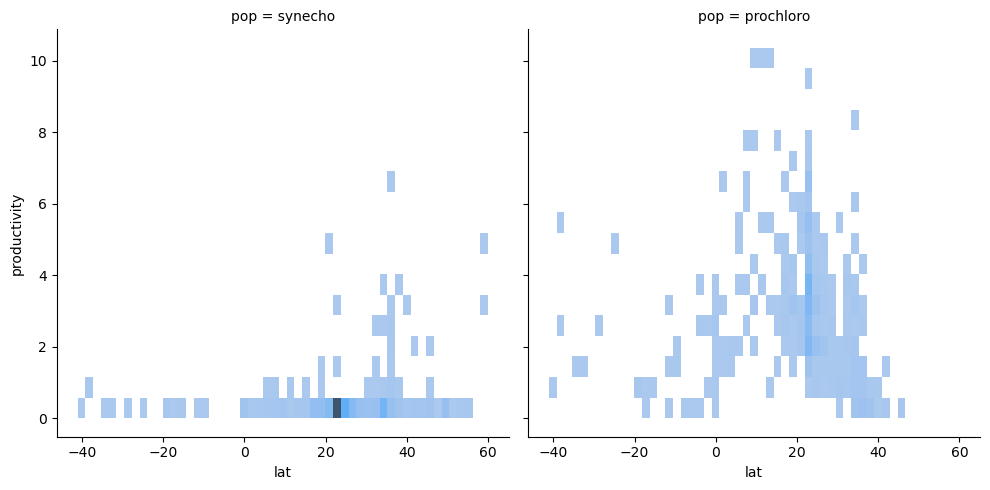

In [101]:
# plot daily rates by latitude
g=sns.displot(
    data=daily_rates, x='lat', y='productivity', col='pop',
)

In [497]:
pd.unique(daily_rates['cruise'])

array(['TN248', 'W1005A', 'TN252', 'TN257', 'TN260', 'CN11ID', 'TN271',
       'TN280', 'CN12ID', 'TN291', 'TN292', 'KN210-04', 'KM1314',
       'CN13ID', 'KM1427', 'KM1502', 'KM1508', 'KM1512', 'KM1513',
       'KM1518', 'KM1601', 'KM1602', 'KOK1604', 'KOK1606', 'KOK1608',
       'KOK1609', 'MGL1704', 'KM1708', 'KM1709', 'KM1712', 'KM1713',
       'KM1717', 'KM1802', 'KM1805', 'FK180310-1', 'FK180310-2',
       'KOK1801', 'KOK1804', 'KOK1805', 'KOK1806', 'KOK1807', 'RR1815',
       'KM1821', 'KM1901', 'KM1903', 'KM1906', 'KM1909', 'KM1912',
       'KM1915', 'KM1917', 'KM1919', 'KM1920', 'SR1917', 'KM1923_740',
       'KM2001', 'KM2002', 'KM2009', 'KM2010', 'KM2011', 'KM2013',
       'KM2014', 'KM2101', 'KM2103', 'KM2104', 'KM2105', 'KM2109',
       'KM2111', 'KM2112', 'RR2106', 'TN396', 'TN397', 'TN398', 'KM2204',
       'KM2205', 'KM2206', 'KM2207', 'KM2208', 'KM2209', 'TN412', 'TN413',
       'TN414'], dtype=object)

In [498]:
gradients=daily_rates.loc[daily_rates['cruise'].isin(['KOK1606', 'TN397'])]

In [496]:
# ## read in saved data
# daily_rates=pd.read_pickle('data/all_seaflow_rate_mixeds.pickle')
# all_tsd=pd.read_pickle('data/all_seaflow_tsd_mixed.pickle')

## round coordinates to bin by every 5 deg
daily_rates['round_lat']=5 * round(daily_rates['lat']/5)
daily_rates['round_lon']=5 * round(daily_rates['lon']/5)
# groupby to get mean and counts
binned_rates=daily_rates.groupby(['round_lat','round_lon','pop']).agg({
    'daily_growth':'mean',
    'productivity':'mean',
    'cruise_day':'count'
}).reset_index()
# do some log transforms
binned_rates['log_obs']=np.log(binned_rates['cruise_day'])
binned_rates['log_prod']=np.log(binned_rates['productivity'])
# plot pro first
pro_binned=binned_rates.loc[(binned_rates['pop']=='picoeuk')&(binned_rates['productivity'].notnull())]
# plot a map
fig=px.scatter_geo(pro_binned, lat='round_lat', lon='round_lon',color='log_prod',size='log_obs')
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True)
fig.update_layout(coloraxis_colorbar=dict(
    title="Productivity",
    tickvals=[np.log(20),np.log(10), np.log(5),np.log(2.0),0, np.log(0.5), np.log(0.1), np.log(0.015)],
    ticktext=['20', '10','5', '2.0','1.0', '0.5','0.1','0.01'],
))

# fig.update_layout(coloraxis_colorbar=dict(
#     title="Productivity",
#     tickvals=[np.log(7),np.log(5), np.log(3),np.log(2.0),0, np.log(0.5), np.log(0.1), np.log(0.015)],
#     ticktext=['7.0', '5.0','3.0', '2.0','1.0', '0.5','0.1','0.01'],
# ))
# fig.update_layout(coloraxis_colorbar=dict(
#     title="Productivity",
#     tickvals=[np.log(2.5),0,np.log(0.5),np.log(0.1), np.log(0.01)],
#     ticktext=['2.5', '1.0', '0.5', '0.1','0.01'],
# ))

## Estimate levels of noise within hot data

In [ ]:
# find continuous in data
test_cruise=hot_cruises.loc[(hot_cruises['cruise']=='SCOPE_4')&(hot_cruises['pop']=='prochloro')]
# find missing days

missing_resamp=test_cruise.reset_index(drop=True).copy()
test_cruise.set_index('time',inplace=True)
# resample and get only fill missing_col values
missing_resamp=test_cruise.resample('1H').agg(pd.Series.sum, 
                                          min_count=1).reset_index()
missing_resamp

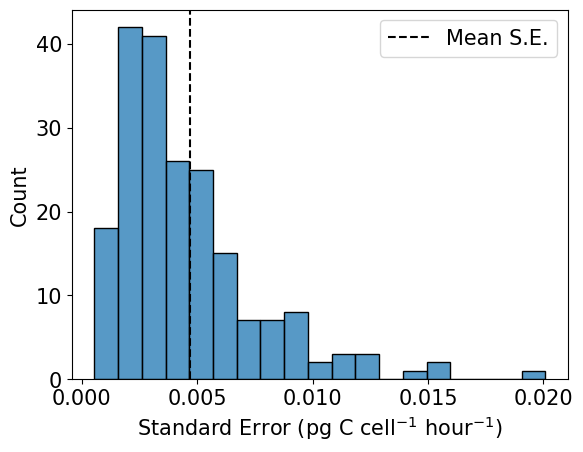

In [278]:
# # save
# hot_cruise_dfs=[]
# # set cruise days for each hot cruise
# for hot_cruise in pd.unique(hot_cruises['cruise']):
#     sub_df=hot_cruises.loc[hot_cruises['cruise']==hot_cruise].reset_index()
#     df_times=find_night(sub_df.copy())
#     hot_days=days_by_sunrise(df_times).drop(columns=['index','time_day'])
#     hot_cruise_dfs.append(hot_days)
# hot_df_days=pd.concat(hot_cruise_dfs)
# # get day values only
# days_only=hot_df_days.loc[(hot_df_days['night']=='sunrise')| (hot_df_days['night']=='day')]
# day_hours=days_only.groupby(['cruise','cruise_day','pop']).agg({
#     'time':'first',
#     'night':'count'
# }).reset_index()
# ## data cleaning
# day_hours['time']=pd.to_datetime(day_hours['time']).dt.date
# days_df['date']=pd.to_datetime(days_df['date']).dt.date
# day_hours=day_hours.loc[day_hours['night']>5]
# # get cruise IDs
# day_hours=day_hours.merge(log[['cruise','Cruise ID']])
# day_hours.drop(columns=['cruise', 'cruise_day'],inplace=True)
# day_hours.rename(columns={'Cruise ID':'cruise', 'time':'date'},inplace=True)
# merged_days=day_hours.merge(days_df)
# merged_days['r_sd']=merged_days['r_se']*np.sqrt(merged_days['night'])
fig,axs=plt.subplots()
sns.histplot(data=days_df, x='r_se',ax=axs)
axs.set_xlabel(r'Standard Error (pg C $\mathregular{cell^{-1}}$ $\mathregular{hour^{-1}}$)')
axs.axvline(x=np.mean(tsd_growth['daily_se']), c='k',linestyle='--', label='Mean S.E.')
axs.legend()
plt.rcParams.update({'font.size':15})

## Rerun Annette's model with new SeaFlow data

In [324]:
## helper function to run Annette's model
def annette_model(df, pop):
    ###### set up data for model ######
    # split by population
    pop_df=df[df['pop']==pop].reset_index(drop=True)

    # must contain at least 30 observations (0.02E6 cells/L)
    abund_threshold=0.02
    # Criteria 1: filter out those with low abundance
    pop_df=pop_df.loc[pop_df['abundance']>=abund_threshold]

    # resample to get missing times
    # set index as time
    missing_resamp=pop_df.reset_index(drop=True).copy()
    pop_df.set_index('time',inplace=True)
    # resample and get only fill missing_col values
    missing_resamp=pop_df.resample('1H').agg(pd.Series.sum, 
                                              min_count=1)#.reset_index()
    # linearly interpolate lat and lon
    missing_resamp['lat']=missing_resamp['lat'].interpolate(method='linear')
    missing_resamp['lon']=missing_resamp['lon'].interpolate(method='linear')
    # set consecutive hours for df throughout length of cruise
    missing_resamp['hour']=np.arange(0,len(missing_resamp))

    # find night and day, and cruise days
    df_times=find_night(missing_resamp.copy().reset_index())
    ############## edge case temp fix ##############
    if len(pd.unique(df_times['night']))<=1:
        # undo date offset for find_night and rerun
        df_times=find_night(df_times, offset=False)
    ################################################
    # get cruise days
    df_days=days_by_sunrise(df_times).drop(columns=['index','time_day'])
    df_days.rename(columns={'night':'time_of_day'},inplace=True)

    # save sunrise df subset
    sr_df=df_days.loc[df_days['time_of_day']=='sunrise']
    ## add dawn values to tsd data
    # calculate day length
    uniq_days=sr_df['time'].dt.round('1d')
    for day in uniq_days:
        # grab abundance and qc values at dawn
        abundance_dawn=sr_df.loc[sr_df['time'].dt.round('1d')==day, 'abundance'].values[0]
        qc_dawn=sr_df.loc[sr_df['time'].dt.round('1d')==day, 'Qc_hour'].values[0]
        # set in impute df
        df_days.loc[df_days['time'].dt.round('1d')==day, 'abundance_dawn']=abundance_dawn
        df_days.loc[df_days['time'].dt.round('1d')==day, 'qc0']=qc_dawn

    # calculate day length and add to tsd data
    ## icriteria 2: day time must be at least 6 hours
    df_days=calc_daylength(df_days)

    # run growth model on data without imputation
    growth_rates=get_daily_growths(df_days, 'Qc_hour')

    ## filter out based on criteria in paper:
    # Criteria 3: pvalue msut be significant (<0.01)
    return(growth_rates.loc[growth_rates['pval']<=0.01])

In [329]:
hot_ids

array(['KM1427', 'KM1508', 'KM1510', 'KM1512', 'KOK1515', 'KM1518',
       'KM1601', 'KM1602', 'KM1603', 'KOK1604', 'KOK1608', 'KOK1609',
       'KM1708', 'KM1712', 'KM1717', 'KM1802', 'FK180310-2', 'KOK1801',
       'KOK1803', 'KOK1804', 'KOK1807', 'KM1821', 'KM1823', 'KM1901',
       'KM1903', 'KM1909', 'KM1912', 'KM1915', 'KM1917', 'KM1924',
       'KM2001', 'KM2002', 'KM2009', 'KM2010', 'KM2011', 'KM2013',
       'KM2014', 'KM2101'], dtype=object)

In [348]:
growth_dfs=[]
for cruise in hot_ids:
    print(cruise)
    for pop in ['prochloro','synecho','picoeuk']:
        print(pop)
        # subset cruise
        cruise_df=hot_clean.loc[(hot_clean['cruise']==cruise)&(hot_clean['pop']==pop)]
        # calculate growth by annette's model
        growth=annette_model(cruise_df,pop)
        growth_dfs.append(growth)

KM1427
prochloro
synecho
picoeuk
KM1508
prochloro
synecho
picoeuk
KM1510
prochloro
synecho
picoeuk
KM1512
prochloro
synecho
picoeuk
KOK1515
prochloro
synecho
picoeuk
KM1518
prochloro
synecho
picoeuk
KM1601
prochloro
synecho
picoeuk
KM1602
prochloro
synecho
picoeuk
KM1603
prochloro
synecho
picoeuk
KOK1604
prochloro
synecho
picoeuk
KOK1608
prochloro
synecho
picoeuk
KOK1609
prochloro
synecho
picoeuk
KM1708
prochloro
synecho
picoeuk
KM1712
prochloro
synecho
picoeuk
KM1717
prochloro
synecho
picoeuk
KM1802
prochloro
synecho
picoeuk
FK180310-2
prochloro
synecho
picoeuk
KOK1801
prochloro
synecho
picoeuk
KOK1803
prochloro
synecho
picoeuk
KOK1804
prochloro
synecho
picoeuk
KOK1807
prochloro
synecho
picoeuk
KM1821
prochloro
synecho
picoeuk
KM1823
prochloro
synecho
picoeuk
KM1901
prochloro
synecho
picoeuk
KM1903
prochloro
synecho
picoeuk
KM1909
prochloro
synecho
picoeuk
KM1912
prochloro
synecho
picoeuk
KM1915
prochloro
synecho
picoeuk
KM1917
prochloro
synecho
picoeuk
KM1924
prochloro
synecho
picoeu

### Comparison to Annette's model: Station ALOHA

In [435]:
# concatenate annette's results
annette_results=pd.concat(growth_dfs)

### combine with Annette's data and plot
HOT_rates=daily_rates.loc[daily_rates['cruise'].isin(hot_ids)]
HOT_rates['model']='TSD'

# clean annette model data for merge
# annette_results.rename(columns={'daily_growth':'daily_growth_ant',
#                               'daily_se':'daily_se_ant','productivity':'PP_exp'},inplace=True)
# annette_results['model']='No Decomposition'
annette_clean.rename(columns={'date':'time','r': 'daily_growth_ant', 'r_se':'daily_se_ant'}, inplace=True)
# merge with tsd data
both_data=HOT_rates.merge(annette_clean, on=['time','pop','cruise'], how='outer')

In [617]:
len(both_data.loc[(both_data['daily_growth_ant'].isnull())
              &(both_data['daily_growth'].notnull())
                 &(both_data['pop']=='prochloro')])

29

In [636]:
len(both_data.loc[(both_data['productivity'].notnull())])

310

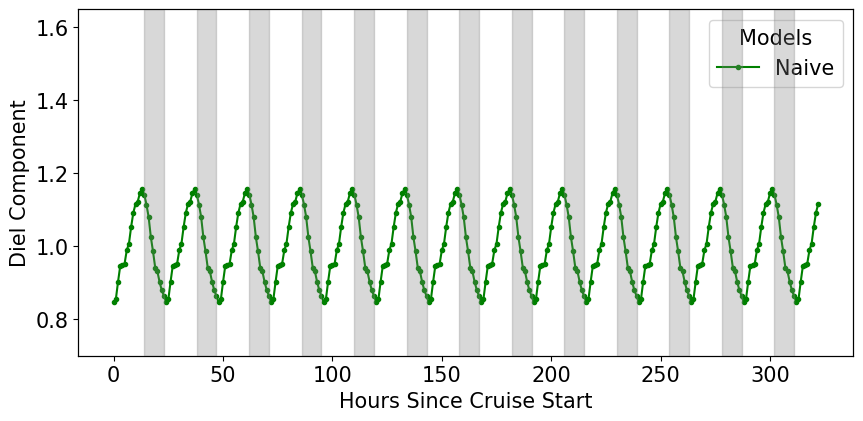

In [584]:
test_naive=g1.loc[g1['model']=='STL']
g1_naive=run_naive(test_naive, 'data_with_missing',period=24)
fig,axs=plt.subplots(figsize=(10,4.5))
x=np.arange(0,len(g1_naive))
axs.plot(x, g1_naive['diel'],marker='.', label='Naive', c='g')
axs.set_ylim(0.7, 1.65)
# add night and day
twinax=axs.twinx()
twinax.fill_between(xSTL, 0, 1, 
                    where=g1.loc[g1['model']=='STL','time_of_day'] == 'night',color='gray', alpha=0.3, 
                    transform=axs.get_xaxis_transform())
# hide y ticks
twinax.tick_params(left=False, labelleft=False, top=False, labeltop=False,
                   right=False, labelright=False, bottom=False, labelbottom=False)

axs.set_xlabel('Hours Since Cruise Start')
axs.set_ylabel('Diel Component')
axs.legend(title='Models')

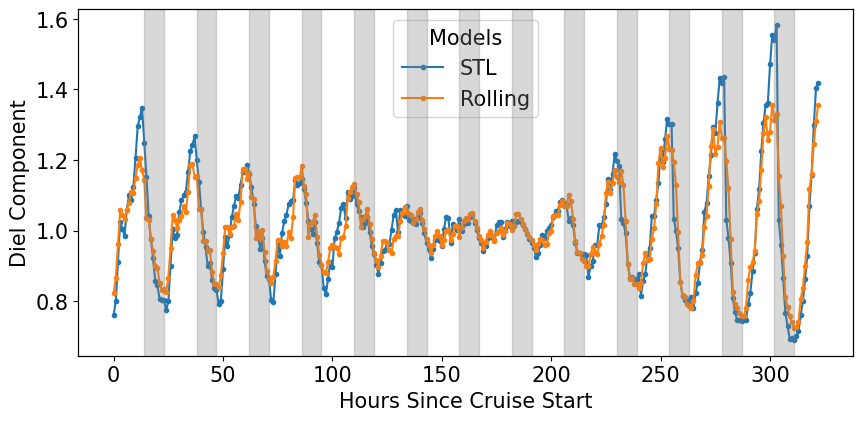

In [575]:
g1=tsd_all.loc[(tsd_all['cruise']=='KOK1606')&
                 (tsd_all['pop']=='prochloro')]
# plot trend
fig,axs=plt.subplots(figsize=(10,4.5))
xSTL=np.arange(0,len(g1.loc[g1['model']=='STL']))
ySTL=g1.loc[g1['model']=='STL', 'diel']
xROLL=np.arange(0,len(g1.loc[g1['model']=='Rolling']))
yROLL=g1.loc[g1['model']=='Rolling', 'diel']
# plot diel components
axs.plot(xSTL,ySTL, marker='.', label='STL')
axs.plot(xROLL,yROLL, marker='.', label='Rolling')
# add night and day
twinax=axs.twinx()
twinax.fill_between(xSTL, 0, 1, 
                    where=g1.loc[g1['model']=='STL','time_of_day'] == 'night',color='gray', alpha=0.3, 
                    transform=axs.get_xaxis_transform())
# hide y ticks
twinax.tick_params(left=False, labelleft=False, top=False, labeltop=False,
                   right=False, labelright=False, bottom=False, labelbottom=False)

axs.set_xlabel('Hours Since Cruise Start')
axs.set_ylabel('Diel Component')
axs.legend(title='Models')

Text(0, 0.5, 'Log Carbon Quota (pg C/cell)')

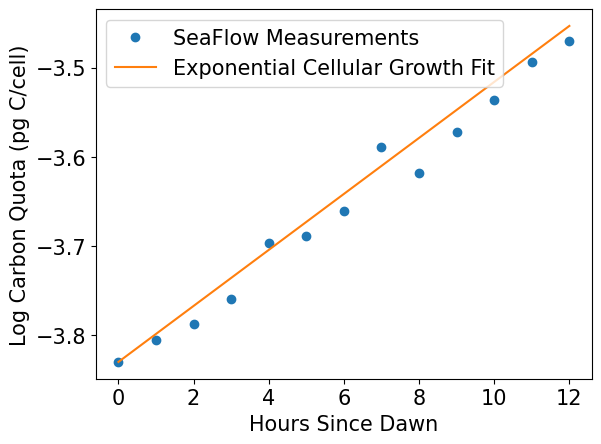

In [592]:
diel=tsd_all.loc[(tsd_all['cruise']=='KM1513')&
                 (tsd_all['pop']=='prochloro')&
                 (tsd_all['cruise_day']==3)&
                (tsd_all['time_of_day']!='night')&
                (tsd_all['model']=='STL')]
test_plot=diel.head(13)
fig,axs=plt.subplots()
yint=np.log(test_plot['data_with_missing'].values[0])
growth=test_plot.daily_growth.values[0]
x=np.arange(0,13)
pred=growth*x+yint


axs.plot(x,np.log(test_plot['data_with_missing']), marker='o', linestyle='', label='SeaFlow Measurements')
axs.plot(x,pred, label='Exponential Cellular Growth Fit')
axs.legend()
axs.set_xlabel('Hours Since Dawn')
axs.set_ylabel('Log Carbon Quota (pg C/cell)')

Text(0, 0.5, 'Log Carbon Quota (pg C/cell)')

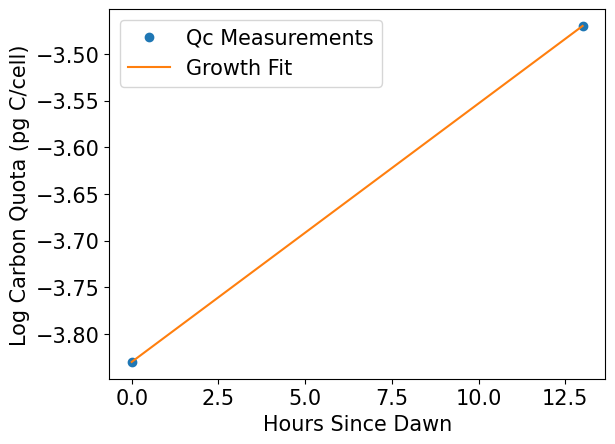

In [615]:
diel=tsd_all.loc[(tsd_all['cruise']=='KM1513')&
                 (tsd_all['pop']=='prochloro')&
                 (tsd_all['cruise_day']==3)&
                (tsd_all['time_of_day']!='night')&
                (tsd_all['model']=='STL')]

test_plot=diel.head(13)
fig,axs=plt.subplots()
yint=np.log(test_plot['data_with_missing'].values[0])
growth=(y[1]-y[0])/13
x1=[0,13]
pred=growth*x1+yint

x2=[0,13]
y=[np.log(test_plot['data_with_missing']).head(1).values, 
   np.log(test_plot['data_with_missing']).tail(1).values]
axs.plot(x2,y, marker='o', linestyle='', label='Qc Measurements')
axs.plot(x1,pred, label='Growth Fit')
axs.legend()
axs.set_xlabel('Hours Since Dawn')
axs.set_ylabel('Log Carbon Quota (pg C/cell)')

## Plot TSD growth rate and productivity results

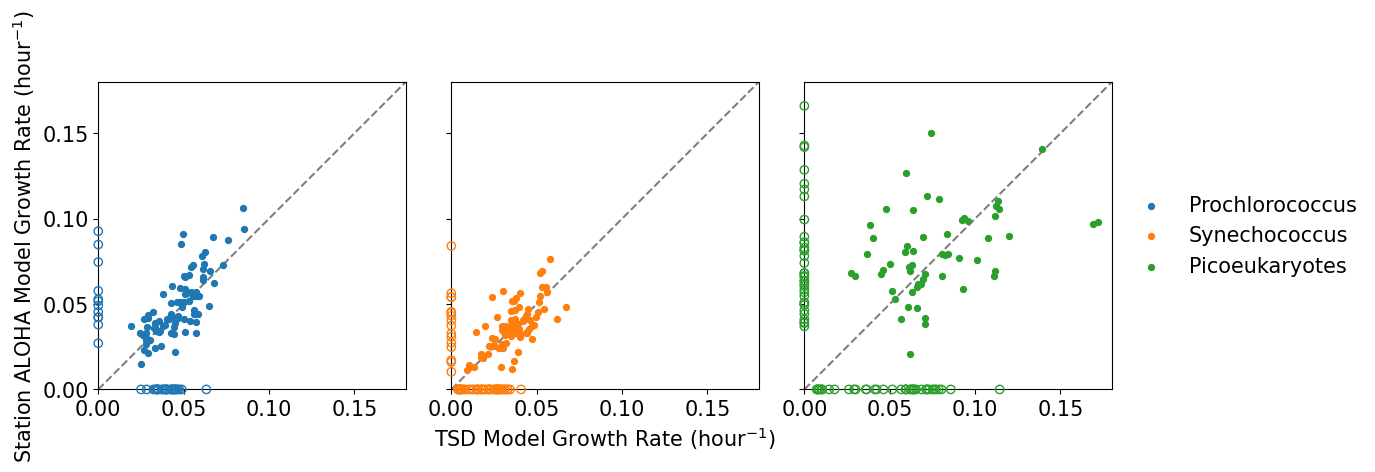

In [465]:
# let's try prelim plot with x and y axis 
fig,axs=plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(14,12))
# set aspect ratio
axs[0].set_box_aspect(1)
axs[1].set_box_aspect(1)
axs[2].set_box_aspect(1)
pro=both_data.loc[both_data['pop']=='prochloro']
syn=both_data.loc[both_data['pop']=='synecho']
pico=both_data.loc[both_data['pop']=='picoeuk']
# plot pro for both
ln1=axs[0].scatter(pro['daily_growth'],pro['daily_growth_ant'],s=18, label='Prochlorococcus')
# plot pro where only tsd model or annette model ran
pro_tsd=pro.loc[pro['daily_growth'].isnull(), 'daily_growth_ant']
pro_ant=pro.loc[pro['daily_growth_ant'].isnull(), 'daily_growth']
axs[0].scatter(np.tile(0,len(pro_tsd)),pro_tsd,facecolors='none', edgecolors='#1f77b4', zorder=10,clip_on=False)
axs[0].scatter(pro_ant,np.tile(0,len(pro_ant)), facecolors='none', edgecolors='#1f77b4', zorder=10,clip_on=False)

# set xy lims
axs[0].set_xlim(0, 0.18)
axs[0].set_ylim(0, 0.18)
## add 1:1 line
lims = [
    np.min([axs[0].get_xlim(), axs[0].get_ylim()]),  # min of both axes
    np.max([axs[0].get_xlim(), axs[0].get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
axs[0].plot(lims, lims, 'k-', alpha=0.5, zorder=0, linestyle='--',label='1:1 line')
# axs[0].legend(bbox_to_anchor=(1, 0.5), frameon=False)

# plot syn
ln2=axs[1].scatter(syn['daily_growth'],syn['daily_growth_ant'],label='Synechococcus', c='#ff7f0e',s=18)
# plot syn where only tsd model or annette model ran
syn_tsd=syn.loc[syn['daily_growth'].isnull(), 'daily_growth_ant']
syn_ant=syn.loc[syn['daily_growth_ant'].isnull(), 'daily_growth']
axs[1].scatter(np.tile(0,len(syn_tsd)),syn_tsd,facecolors='none', edgecolors='#ff7f0e', zorder=10,clip_on=False)
axs[1].scatter(syn_ant,np.tile(0,len(syn_ant)), facecolors='none', edgecolors='#ff7f0e', zorder=10,clip_on=False)
# add 1:1 line
axs[1].plot(lims, lims, 'k-', alpha=0.5, zorder=0, linestyle='--')

# plot pico
ln3=axs[2].scatter(pico['daily_growth'],pico['daily_growth_ant'],label='Picoeukaryotes', c='#2ca02c',s=18)
# plot pico where only tsd model or annette model ran
pico_tsd=pico.loc[pico['daily_growth'].isnull(), 'daily_growth_ant']
pico_ant=pico.loc[pico['daily_growth_ant'].isnull(), 'daily_growth']
axs[2].scatter(np.tile(0,len(pico_tsd)),pico_tsd,facecolors='none', edgecolors='#2ca02c', zorder=10,clip_on=False)
axs[2].scatter(pico_ant,np.tile(0,len(pico_ant)), facecolors='none', edgecolors='#2ca02c', zorder=10,clip_on=False)
# add 1:1 line
axs[2].plot(lims, lims, 'k-', alpha=0.5, zorder=0, linestyle='--')

# plot combined legend
lns=[ln1,ln2, ln3]
labs = [l.get_label() for l in lns]
axs[2].legend(lns,labs,loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)


# add axis labels
axs[1].set_xlabel('TSD Model Growth Rate ($\mathregular{hour^{-1}}$)')
# axs[0].set_ylabel('Model 2 Growth Rate (hour-1)')
axs[0].set_ylabel('Station ALOHA Model Growth Rate ($\mathregular{hour^{-1}}$)')
plt.rcParams.update({'font.size':15})
plt.tight_layout()

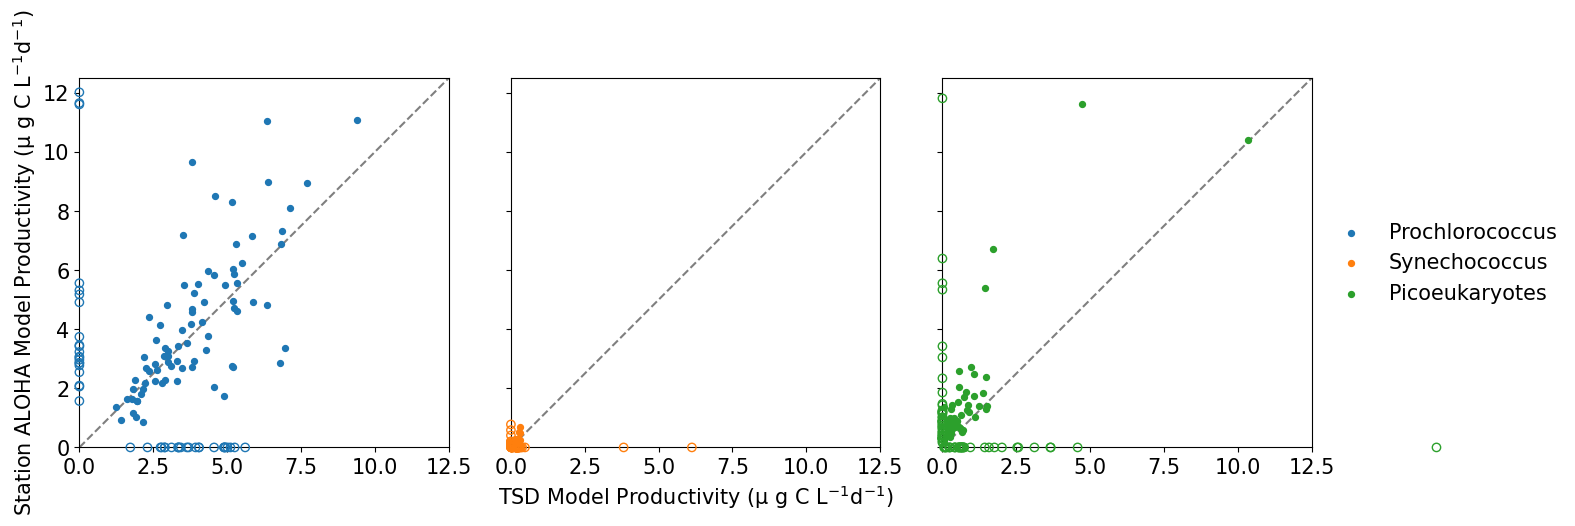

In [641]:
# let's try prelim plot with x and y axis 
fig,axs=plt.subplots(ncols=3, figsize=(16,14), sharex=True, sharey=True)
# set aspect ratio
axs[0].set_box_aspect(1)
axs[1].set_box_aspect(1)
axs[2].set_box_aspect(1)
pro=both_data.loc[both_data['pop']=='prochloro']
syn=both_data.loc[both_data['pop']=='synecho']
pico=both_data.loc[both_data['pop']=='picoeuk']
# plot pro for both
ln1=axs[0].scatter(pro['productivity'],pro['PP_exp'],s=18, label='Prochlorococcus')
# plot pro where only tsd model or annette model ran
pro_tsd=pro.loc[pro['productivity'].isnull(), 'PP_exp']
pro_ant=pro.loc[pro['PP_exp'].isnull(), 'productivity']
axs[0].scatter(np.tile(0,len(pro_tsd)),pro_tsd,facecolors='none', edgecolors='#1f77b4', zorder=10,clip_on=False)
axs[0].scatter(pro_ant,np.tile(0,len(pro_ant)), facecolors='none', edgecolors='#1f77b4', zorder=10,clip_on=False)

# set xy lims
# set xy lims for each axis
axs[0].set_xlim(0, 12.5)
axs[0].set_ylim(0, 12.5)
# axs[1].set_xlim(0, 0.8)
# axs[1].set_ylim(0, 0.8)
# axs[2].set_xlim(0, 12.5)
# axs[2].set_ylim(0, 12.5)
## add 1:1 line
lims = [
    np.min([axs[0].get_xlim(), axs[0].get_ylim()]),  # min of both axes
    np.max([axs[0].get_xlim(), axs[0].get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
axs[0].plot(lims, lims, 'k-', alpha=0.5, zorder=0, linestyle='--',label='1:1 line')
# axs[0].legend(bbox_to_anchor=(1, 0.5), frameon=False)

# plot syn
ln2=axs[1].scatter(syn['productivity'],syn['PP_exp'],label='Synechococcus', c='#ff7f0e',s=18)
# plot syn where only tsd model or annette model ran
syn_tsd=syn.loc[syn['productivity'].isnull(), 'PP_exp']
syn_ant=syn.loc[syn['PP_exp'].isnull(), 'productivity']
axs[1].scatter(np.tile(0,len(syn_tsd)),syn_tsd,facecolors='none', edgecolors='#ff7f0e', zorder=10,clip_on=False)
axs[1].scatter(syn_ant,np.tile(0,len(syn_ant)), facecolors='none', edgecolors='#ff7f0e', zorder=10,clip_on=False)
# add 1:1 line
axs[1].plot(lims, lims, 'k-', alpha=0.5, zorder=0, linestyle='--')

# plot pico
ln3=axs[2].scatter(pico['productivity'],pico['PP_exp'],label='Picoeukaryotes', c='#2ca02c',s=18)
# plot pico where only tsd model or annette model ran
pico_tsd=pico.loc[pico['productivity'].isnull(), 'PP_exp']
pico_ant=pico.loc[pico['PP_exp'].isnull(), 'productivity']
axs[2].scatter(np.tile(0,len(pico_tsd)),pico_tsd,facecolors='none', edgecolors='#2ca02c', zorder=10,clip_on=False)
axs[2].scatter(pico_ant,np.tile(0,len(pico_ant)), facecolors='none', edgecolors='#2ca02c', zorder=10,clip_on=False)
# add 1:1 line
axs[2].plot(lims, lims, 'k-', alpha=0.5, zorder=0, linestyle='--')

# plot combined legend
lns=[ln1,ln2, ln3]
labs = [l.get_label() for l in lns]
axs[2].legend(lns,labs,loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)


# add axis labels
axs[1].set_xlabel('TSD Model Productivity (µ g C $\mathregular{L^{-1} d^{-1}}$)')
# axs[0].set_ylabel('Model 2 Growth Rate (hour-1)')
axs[0].set_ylabel('Station ALOHA Model Productivity (µ g C $\mathregular{L^{-1} d^{-1}}$)')
plt.rcParams.update({'font.size':15})
plt.tight_layout()

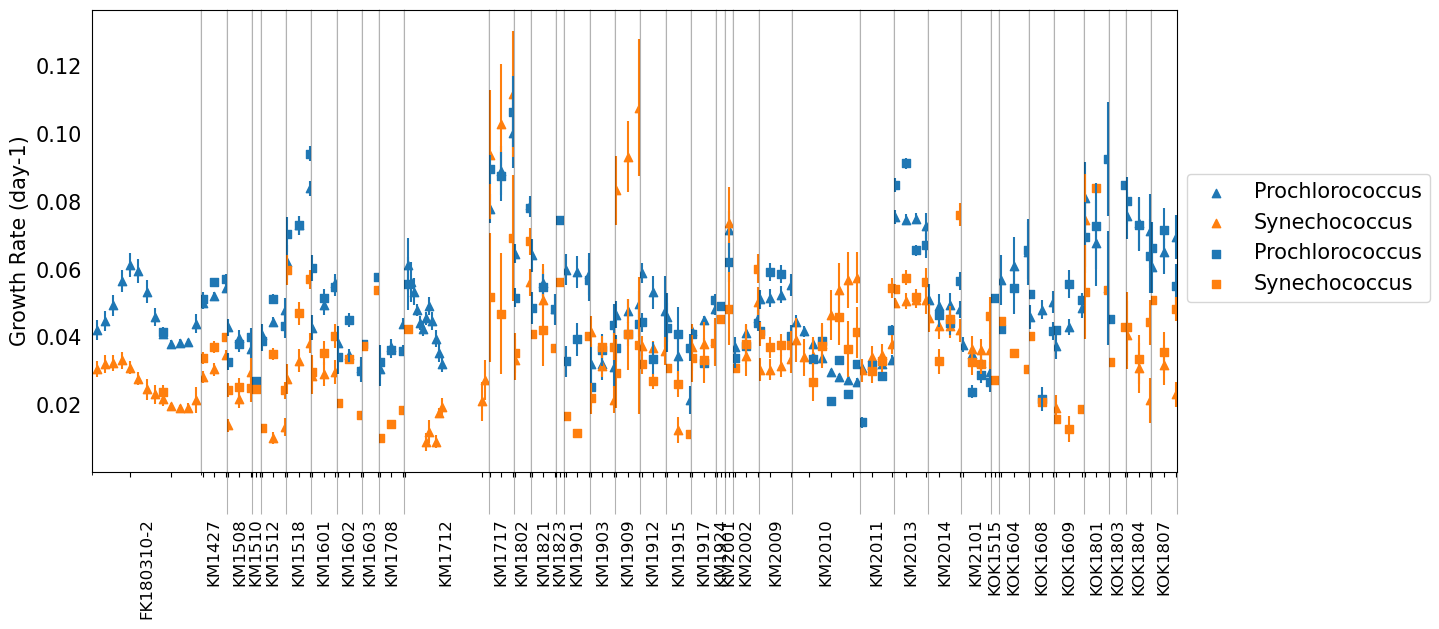

In [242]:
test1=both_data.copy()
# sns.lineplot(data=test1, x='cruise_day',y='daily_growth',hue='pop',marker='o')
# set multi index
test1.set_index(['cruise', 'cruise_day'], inplace=True)
# define zones and number of plots
zones = test1.index.levels[0]
nplots = zones.size
# define plot width ratio for each zone (cruise)
plots_width_ratios = [test1.xs(zone).index.size*3 for zone in zones]
fig, axes = plt.subplots(nrows=1, ncols=nplots, sharey=True, figsize=(14, 6),
                         gridspec_kw = dict(width_ratios=plots_width_ratios, wspace=0))

# Loop through array of axes to create grouped bar chart for each cruise
alpha = 0.3 # used for grid lines, bottom spine and separation lines between zones
count=0
for zone, ax in zip(zones, axes):
    # plot data
    # need seprate matplotlib plots bc seaborn still doesn't do custom error bars :/
    df=test1.xs(zone).reset_index()
    # get tsd data
    pro_tsd=df.loc[(df['pop']=='prochloro')&(df['model_x']=='TSD')]
    syn_tsd=df.loc[(df['pop']=='synecho')&(df['model_x']=='TSD')]
    # get annette data
    pro_ant=df.loc[(df['pop']=='prochloro')&(df['model_y']=='No Decomposition')]
    syn_ant=df.loc[(df['pop']=='synecho')&(df['model_y']=='No Decomposition')]
    # check if annette's data has cruise days
    if pro_ant['cruise_day'].isnull().any():
        # sort df by time
        pro_ant=pro_ant.sort_values(by='time')
        # reset cruise days
        pro_ant['cruise_day']=np.arange(1,len(pro_ant)+1)
    if syn_ant['cruise_day'].isnull().any():
        # sort df by time
        syn_ant=syn_ant.sort_values(by='time')
        # reset cruise days
        syn_ant['cruise_day']=np.arange(1,len(syn_ant)+1)
    
    # plot data
#     ax.scatter(pro_tsd['cruise_day'],pro_tsd['daily_growth'],label='TSD', c='k', marker='^')
#     ax.scatter(pro_ant['cruise_day'],pro_ant['daily_growth_ant'],label='No Decomposition', c='k', marker='s')
    ax.scatter(pro_tsd['cruise_day'],pro_tsd['daily_growth'],label='Prochlorococcus', c='#1f77b4', marker='^')
    ax.scatter(syn_tsd['cruise_day'],syn_tsd['daily_growth'],label='Synechococcus',c='#ff7f0e', marker='^')
    ax.scatter(pro_ant['cruise_day'],pro_ant['daily_growth_ant'],label='Prochlorococcus', c='#1f77b4', marker='s')
    ax.scatter(syn_ant['cruise_day'],syn_ant['daily_growth_ant'],label='Synechococcus',c='#ff7f0e', marker='s')
#     # add error bars
    ax.errorbar(pro_tsd['cruise_day'],pro_tsd['daily_growth'],yerr=pro_tsd['daily_se'],ls='none', c='#1f77b4')
    ax.errorbar(syn_tsd['cruise_day'],syn_tsd['daily_growth'],yerr=syn_tsd['daily_se'],ls='none', c='#ff7f0e')
    ax.errorbar(pro_ant['cruise_day'],pro_ant['daily_growth_ant'],yerr=pro_ant['daily_se'],ls='none', c='#1f77b4')
    ax.errorbar(syn_ant['cruise_day'],syn_ant['daily_growth_ant'],yerr=syn_ant['daily_se'],ls='none', c='#ff7f0e')
#     sns.scatterplot(data=test1.xs(zone), x='cruise_day',y='daily_growth',
#                     hue='pop',ax=ax,legend=None,marker='o',zorder=2,size=1.5)
    
    # adjust spines in the middle
    if count>0:
        ax.spines['left'].set_alpha(alpha)
    
    # Set and place x labels for cruises
    ax.set_xlabel(zone,rotation='vertical',size=12)
    # rotate
    ax.xaxis.set_label_coords(x=0.5, y=-0.1)
    # axis aesthetics
    ax.tick_params(left = False)
    count+=1
    
    # hide cruise days
    ax.tick_params(labelbottom=False) 
    
    #format tick separations
    if ax.is_first_col():
        ax.set_xticks([*ax.get_xlim()], minor=True)
        ax.set_ylabel('Growth Rate (day-1)',size=15)
        ax.tick_params(axis='y', labelsize=15)
    else:
        ax.set_xticks([ax.get_xlim()[1]], minor=True)
        ax.tick_params(which='minor', length=30, width=0.8, color=[0, 0, 0, alpha])
        
# fig.text(0.04, 0.5, 'Growth Rate (hour-1)', va='center', rotation='vertical')
# Add legend using the labels and handles from the last subplot
fig.legend(*ax.get_legend_handles_labels(),frameon=True, loc='center left', bbox_to_anchor=(0.9, 0.5),
          prop={'size': 15})
plt.show()

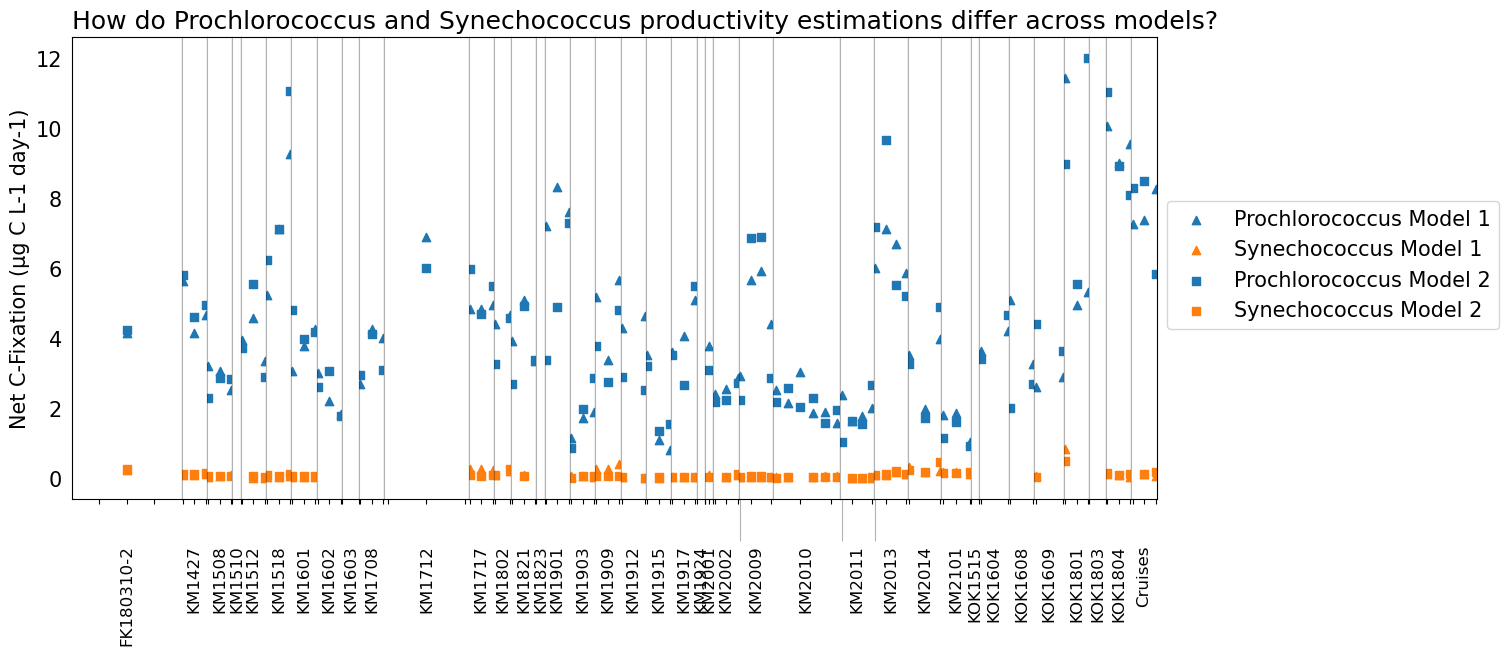

In [243]:
### calculate productivity by annette's method
# for now, merge annette's model and ours
### combine with Annette's data and plot
tsd_growth=pd.concat(growth_rates)
# filter out bad pvalues
good_tsd=tsd_growth.loc[(tsd_growth['pval']<=0.01)&(tsd_growth['daily_growth']>0)]
good_tsd['model']='TSD'
# change cruise names to match cruise IDs in annette's dataset
good_tsd=good_tsd.merge(log[['cruise','Cruise ID']])
good_tsd.drop(columns=['cruise'],inplace=True)
good_tsd.rename(columns={'Cruise ID':'cruise'},inplace=True)

# clean annette model data for merge
annette_clean=days_df[['date','pop','cruise','r','r_se','abundance_dawn','daylength', 'log_Qc0','PP_exp']]
annette_clean.rename(columns={'r':'daily_growth_ant','r_se':'daily_se_ant','date':'time'},inplace=True)
annette_clean['time']=pd.to_datetime(annette_clean['time']).dt.date
annette_clean['model']='No Decomposition'
# merge with tsd data
both_data=good_tsd.merge(annette_clean, on=['time','pop','cruise'])
# get Qc at sunrise
both_data['Qc0']=np.exp(both_data['log_Qc0'])
# calculate productivity
both_data['productivity_tsd']=both_data['abundance_dawn']*both_data['Qc0']*(np.exp(both_data['daily_growth']*both_data['daylength']) - 1)


#### plot productivity
test=both_data.copy()
# # sns.lineplot(data=test, x='cruise_day',y='daily_growth',hue='pop',marker='o')
# # set multi index
test.set_index(['cruise', 'cruise_day'], inplace=True)
# # define zones and number of plots
# zones = test.index.levels[0]
# nplots = zones.size
# # define plot width ratio for each zone (cruise)
# plots_width_ratios = [test.xs(zone).index.size*3 for zone in zones]
fig, axes = plt.subplots(nrows=1, ncols=nplots, sharey=True, figsize=(14, 6),
                         gridspec_kw = dict(width_ratios=plots_width_ratios, wspace=0))

# Loop through array of axes to create grouped bar chart for each cruise
alpha = 0.3 # used for grid lines, bottom spine and separation lines between zones
count=0
for zone, ax in zip(zones, axes):
    # plot data
    # adjust spines in the middle
    if count>0:
        ax.spines['left'].set_alpha(alpha)
    
    # Set and place x labels for cruises
    ax.set_xlabel(zone,rotation='vertical',size=12)
    # rotate
    ax.xaxis.set_label_coords(x=0.5, y=-0.1)
    # axis aesthetics
    ax.tick_params(left = False)
    count+=1
    
    # hide cruise days
    ax.tick_params(labelbottom=False) 
    
    #format tick separations
    if ax.is_first_col():
        ax.set_xticks([*ax.get_xlim()], minor=True)
        ax.set_ylabel('Net C-Fixation (µg C L-1 day-1)',size=15)
        ax.tick_params(axis='y', labelsize=15)
        ax.set_title('How do Prochlorococcus and Synechococcus productivity estimations differ across models?',
                    loc='left', size=18)
    else:
        ax.set_xticks([ax.get_xlim()[1]], minor=True)
        ax.tick_params(which='minor', length=30, width=0.8, color=[0, 0, 0, alpha])
    # need seprate matplotlib plots bc seaborn still doesn't do custom error bars :/
    # check if zone is present in the cruise
    if zone not in test.index:
        continue
    df=test.xs(zone).reset_index()
    # get tsd data
    pro_tsd=df.loc[(df['pop']=='prochloro')&(df['model_x']=='TSD')]
    syn_tsd=df.loc[(df['pop']=='synecho')&(df['model_x']=='TSD')]
    # get annette data
    pro_ant=df.loc[(df['pop']=='prochloro')&(df['model_y']=='No Decomposition')]
    syn_ant=df.loc[(df['pop']=='synecho')&(df['model_y']=='No Decomposition')]
    
    # plot data
#     ax.scatter(pro_tsd['cruise_day'],pro_tsd['daily_growth'],label='TSD', c='k', marker='^')
#     ax.scatter(pro_ant['cruise_day'],pro_ant['daily_growth_ant'],label='No Decomposition', c='k', marker='s')
    ax.scatter(pro_tsd['cruise_day'],pro_tsd['productivity_tsd'],label='Prochlorococcus Model 1', c='#1f77b4', marker='^')
    ax.scatter(syn_tsd['cruise_day'],syn_tsd['productivity_tsd'],label='Synechococcus Model 1',c='#ff7f0e', marker='^')
    ax.scatter(pro_ant['cruise_day'],pro_ant['PP_exp'],label='Prochlorococcus Model 2', c='#1f77b4', marker='s')
    ax.scatter(syn_ant['cruise_day'],syn_ant['PP_exp'],label='Synechococcus Model 2',c='#ff7f0e', marker='s')
#     # add error bars
        
# fig.text(0.04, 0.5, 'Growth Rate (hour-1)', va='center', rotation='vertical')
# Add legend using the labels and handles from the last subplot
fig.legend(*ax.get_legend_handles_labels(),frameon=True, loc='center left', bbox_to_anchor=(0.9, 0.5),
          prop={'size': 15})

plt.xlabel('Cruises')
plt.show()

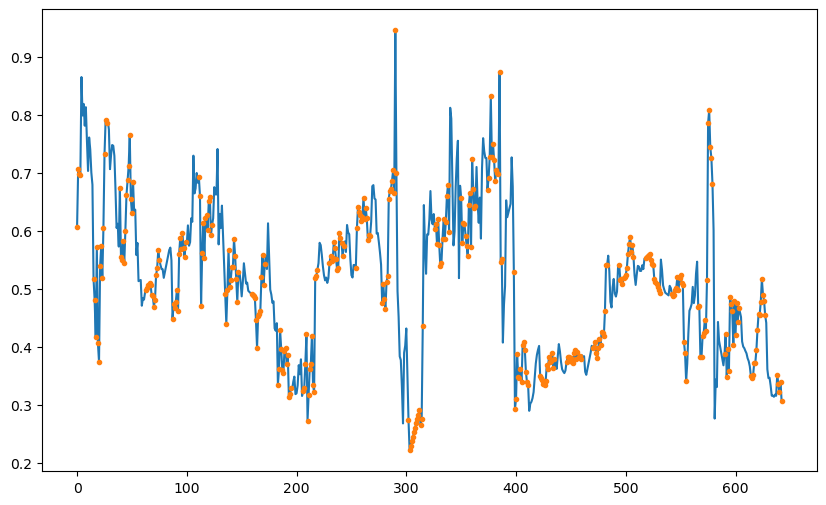

In [131]:
fig,axs=plt.subplots(figsize=(10,6))
test=tsd_df
axs.plot(test['data_with_missing'])
axs.plot(test.loc[(test['time_of_day']!='night')&(test['time_of_day']!='sunset'),
                    'data_with_missing'],marker='.',linestyle='')

## Make table of all productivity and growth rate values!

## comparision to NPP

In [131]:
import pycmap
api = pycmap.API(token='ec600c40-bb53-11ec-9220-c1bedea45ab3')
group_tbl='tblHOT242_252_14C_PP_WSW_group_sort'
# grab group specifc first
group_df=api.get_dataset(group_tbl)
# only surface
surface=group_df.loc[group_df['depth']<10]
surface['time']=pd.to_datetime(surface['time'])
surface['day']=surface['time'].dt.round("1d")
# melt df
cols=['day','C14_assimilation_prochlorococcus',
        'C14_assimilation_synechococcus','C14_assimilation_pico']
surface_sub=surface[cols]
surface_sub.rename(columns={cols[1]:'pro', cols[2]: 'syn', cols[3]: 'picoeuks'}, inplace=True)
surface_long=pd.melt(surface_sub, id_vars=['day'], var_name='pop',value_name='C14_assimilation')
# convert µmol to g (molar mass=18.035 g/mol according to NIH)
surface_long['C14_assimilation_ug']=surface_long['C14_assimilation']*18.035

In [251]:
surface['day'].values

array(['2012-02-14T00:00:00.000000000', '2012-03-07T00:00:00.000000000',
       '2012-04-06T00:00:00.000000000', '2012-05-18T00:00:00.000000000',
       '2012-05-30T00:00:00.000000000', '2012-06-25T00:00:00.000000000',
       '2012-08-18T00:00:00.000000000', '2012-09-15T00:00:00.000000000',
       '2012-10-19T00:00:00.000000000', '2012-12-04T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [254]:
both_data.sort_values(by='time')

,time,pop,daily_growth,daily_se,pval,cruise_day,model_x,cruise,daily_growth_ant,daily_se_ant,abundance_dawn,daylength,log_Qc0,PP_exp,model_y,Qc0,productivity_tsd
0,2014-12-09,prochloro,0.050241,0.001899,7.613419e-10,1.0,TSD,KM1427,0.051410,0.005004,322.434128,10.775278,-3.712520,5.826689,No Decomposition,0.024416,5.655246
3,2014-12-09,synecho,0.028340,0.001818,8.089121e-08,1.0,TSD,KM1427,0.033920,0.003607,2.132409,10.775278,-1.968471,0.131416,No Decomposition,0.139670,0.106365
1,2014-12-10,prochloro,0.052033,0.001185,8.209877e-12,2.0,TSD,KM1427,0.056282,0.002872,229.292700,10.769167,-3.725399,4.605359,No Decomposition,0.024103,4.152218
4,2014-12-10,synecho,0.030555,0.001845,4.759763e-08,2.0,TSD,KM1427,0.037150,0.004615,2.086144,10.769167,-2.042725,0.133078,No Decomposition,0.129675,0.105408
2,2014-12-11,prochloro,0.054670,0.001449,2.679028e-10,3.0,TSD,KM1427,0.057272,0.001558,245.266165,10.763611,-3.741046,4.960686,No Decomposition,0.023729,4.662904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,2021-01-12,synecho,0.036578,0.003890,5.956152e-06,1.0,TSD,KM2101,0.032815,0.011374,2.984452,10.860278,-2.098612,0.156691,No Decomposition,0.122627,0.178493
154,2021-01-13,synecho,0.036361,0.003063,8.429947e-07,2.0,TSD,KM2101,0.032261,0.002645,3.284346,10.871667,-2.125615,0.164690,No Decomposition,0.119360,0.190066
151,2021-01-13,prochloro,0.032515,0.002249,1.551289e-07,2.0,TSD,KM2101,0.028837,0.001413,159.411946,10.871667,-3.588588,1.622253,No Decomposition,0.027637,1.868186
152,2021-01-14,prochloro,0.029861,0.002959,3.313503e-06,3.0,TSD,KM2101,0.026838,0.001572,104.488288,10.882778,-3.635056,0.935044,No Decomposition,0.026382,1.058525


In [252]:
# maybe try to match by days?
both_data[both_data['time'].isin(surface['day'].values)]

,time,pop,daily_growth,daily_se,pval,cruise_day,model_x,cruise,daily_growth_ant,daily_se_ant,abundance_dawn,daylength,log_Qc0,PP_exp,model_y,Qc0,productivity_tsd


### OLD CODE

In [ ]:
test=tsd_results[0]
test_growth=growth_rates[0]
pro=test.loc[test['pop']=='prochloro']
growth_col='daily_growth'

pro_bkps=pelt_bkps(pro['trend'], 'Prochlorococcus')
pro['bkps']=make_bkps(pro_bkps)

# find mean trend per change point
mean_bkps=pro.groupby(['pop','bkps']).agg({
    'trend':'mean'}).reset_index()
# rename col
mean_bkps.rename(columns={'trend':'mean_bkp'},inplace=True)

# merge with df with growth col
prod_df=pro.merge(mean_bkps)
# calculate productivity 
prod_df['productivity']=prod_df[growth_col]*prod_df['mean_bkp']
prod_df
# # get daily mean
# daily_rates=merge_bkps.groupby(['cruise_day','pop']).mean().reset_index()
# # syn_bkps=pelt_bkps(syn_trend, 'Synechococcus')

In [17]:
## preliminary data cleaning 
# run linear interpolation helper function to fill in missing data
pro_res = interp_by_time(cruise_daily, 'prochloro')
syn_res = interp_by_time(cruise_daily, 'synecho')

# get data to run in model
pro_diam=pro_res['diam_med']
syn_diam=syn_res['diam_med']

0.07113686540614894


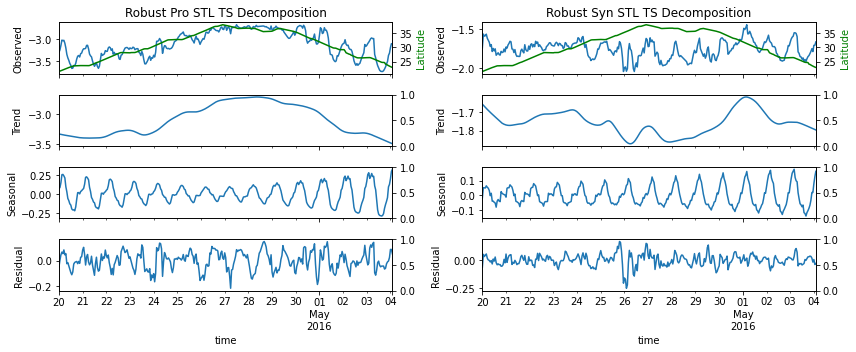

In [18]:
# Run robust STL to start with 
# No rolling (multiplicative)
period=24
robust_fit_pro = STL(np.log(pro_diam), period=period, robust=False, seasonal=15)
robust_fit_syn = STL(np.log(syn_diam), period=period, robust=False, seasonal=15)
robust_stl_pro = robust_fit_pro.fit()
robust_stl_syn = robust_fit_syn.fit()

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(12,5))
plotseasonal(robust_stl_pro, axes[:,0], pop='Robust Pro STL', lat=pro_res['lat'])
plotseasonal(robust_stl_syn, axes[:,1], pop='Robust Syn STL', lat=syn_res['lat'])
plt.tight_layout()

# print error
# print error
y_true=robust_stl_pro.observed
y_pred=robust_stl_pro.trend+robust_stl_pro.seasonal
rmse=mean_squared_error(y_true, y_pred,squared=False)
print(rmse)

In [21]:
pro_trend=np.exp(robust_stl_pro.trend.values.reshape(-1,1))
pro_res['trend']=pro_trend
syn_trend=np.exp(robust_stl_syn.trend.values.reshape(-1,1))
syn_res['trend']=syn_trend
pro_bkps=pelt_bkps(pro_trend, 'Prochlorococcus')
syn_bkps=pelt_bkps(syn_trend, 'Synechococcus')

In [26]:
# create unique breakpoints
pro_res['bkps']=make_bkps(pro_bkps)
syn_res['bkps']=make_bkps(syn_bkps)
# concatenate together
g1_all_bkps=pd.concat([pro_res,syn_res])

In [27]:
# calculate daily growth (daily hourly average)
g1_hourly,g1_avg_growth=calc_daily_hourly_growth(cruise_daily)

In [28]:
# merge bkps with growth data
growth_bkps=g1_all_bkps.reset_index()[['time','lat','lon','pop','trend','bkps']].merge(g1_hourly)
# find mean trend per change point
mean_bkps=growth_bkps.groupby(['pop','bkps']).agg({
    'trend':'mean'}).reset_index()
# rename col
mean_bkps.rename(columns={'trend':'mean_bkp'},inplace=True)
# merge with growth data
merge_bkps=growth_bkps.merge(mean_bkps)
# calculate productivity 
merge_bkps['prod']=merge_bkps['hourly_growth']*merge_bkps['mean_bkp']
# get daily mean
daily_rates=merge_bkps.groupby(['cruise_day','pop']).mean().reset_index()

In [29]:
# merge bkps with growth data
growth_bkps=g1_all_bkps.reset_index()[['time','lat','lon','pop','trend','bkps']].merge(g1_hourly)
# find mean trend per change point
mean_bkps=growth_bkps.groupby(['pop','bkps']).agg({
    'trend':'mean'}).reset_index()
# rename col
mean_bkps.rename(columns={'trend':'mean_bkp'},inplace=True)
# merge with growth data
merge_bkps=growth_bkps.merge(mean_bkps)
# calculate productivity 
merge_bkps['prod']=merge_bkps['hourly_growth']*merge_bkps['mean_bkp']
# get daily mean
daily_rates=merge_bkps.groupby(['cruise_day','pop']).mean().reset_index()

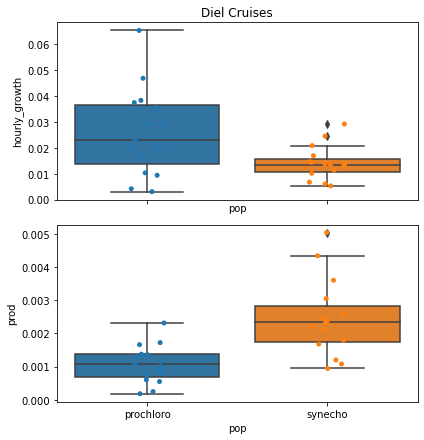

In [31]:
# make scattered box plot
fig,axs=plt.subplots(nrows=2,sharex=True, figsize=(6,6))
# creating boxplot 
sns.boxplot(x='pop', y='hourly_growth', data=daily_rates,ax=axs[0]) 
# adding data points 
ax=sns.stripplot(x='pop', y='hourly_growth', data=daily_rates,ax=axs[0]) 

# creating boxplot 
sns.boxplot(x='pop', y='prod', data=daily_rates,ax=axs[1]) 
# adding data points 
ax=sns.stripplot(x='pop', y='prod', data=daily_rates,ax=axs[1]) 
plt.tight_layout()
# add title
axs[0].set_title('Diel Cruises')
# display plot 
plt.show() 

## Functions here!

In [32]:
# function to run STL model
## input: cruise df
## output: pro_res = dataframe with cleaned tsd components for pro, syn_res=same but with syn
def run_STL(cruise):
    ## preliminary data cleaning 
    # run linear interpolation helper function to fill in missing data
    pro_res = interp_by_time(cruise, 'prochloro')
    syn_res = interp_by_time(cruise, 'synecho')

    # get data to run in model
    pro_diam=pro_res['diam_med']
    syn_diam=syn_res['diam_med']
    
    # Run robust STL to start with 
    # No rolling (multiplicative)
    period=24
    robust_fit_pro = STL(np.log(pro_diam), period=period, robust=False, seasonal=15)
    robust_fit_syn = STL(np.log(syn_diam), period=period, robust=False, seasonal=15)
    robust_stl_pro = robust_fit_pro.fit()
    robust_stl_syn = robust_fit_syn.fit()
    
    # add trend components to datasets
    pro_trend=np.exp(robust_stl_pro.trend.values.reshape(-1,1))
    pro_res['trend']=pro_trend
    syn_trend=np.exp(robust_stl_syn.trend.values.reshape(-1,1))
    syn_res['trend']=syn_trend
    # return both components
    return pro_res,syn_res

In [35]:
def calc_growth_prod(cruise):
    # run STL tsd to get trend components
    name=pd.unique(cruise.cruise)[0]
    pro_res, syn_res=run_STL(cruise)
    # get breakpoints from PELT algorithm
    pro_bkps=pelt_bkps(pro_res.trend.values.reshape(-1,1), 'Prochlorococcus')
    syn_bkps=pelt_bkps(syn_res.trend.values.reshape(-1,1), 'Synechococcus')
    # define unique breakpoints in df
    pro_res['bkps']=make_bkps(pro_bkps)
    syn_res['bkps']=make_bkps(syn_bkps)
    # concatenate together
    all_bkps=pd.concat([pro_res,syn_res])

    # calculate growth
    hourly=calc_daily_hourly_growth(cruise)[0]

    # merge bkps with growth data
    growth_bkps=all_bkps.reset_index()[['time','lat','lon','pop','trend','bkps','temp']].merge(hourly)
    # find mean trend per change point
    mean_bkps=growth_bkps.groupby(['pop','bkps']).agg({
        'trend':'mean'}).reset_index()
    # rename col
    mean_bkps.rename(columns={'trend':'mean_bkp'},inplace=True)
    # merge with growth data
    merge_bkps=growth_bkps.merge(mean_bkps)
    # calculate productivity 
    merge_bkps['prod']=merge_bkps['hourly_growth']*merge_bkps['mean_bkp']
    # get daily mean
    daily_rates=merge_bkps.groupby(['cruise_day','pop']).mean().reset_index()
    daily_rates['cruise']=name
    # throw out the negative ones
    return daily_rates.loc[daily_rates['hourly_growth']>0]

In [36]:
def rates_box_plot(df,title):
    # make scattered box plot
    fig,axs=plt.subplots(nrows=2,sharex=True, figsize=(8,7))
    # creating boxplot 
    sns.boxplot(x='pop', y='hourly_growth', data=df,ax=axs[0]) 
    # adding data points 
    sns.stripplot(x='pop', y='hourly_growth', data=df,ax=axs[0]) 
    axs[0].ylabel='Daily Averaged Hourly Growth (-hour)'
    axs[0].set_ylim(0,0.12)
    

    # creating boxplot 
    sns.boxplot(x='pop', y='prod', data=df,ax=axs[1]) 
    # adding data points 
    sns.stripplot(x='pop', y='prod', data=df,ax=axs[1])
    axs[1].ylabel='Daily Averaged Hourly Productivity (pg C/cell*hour)'
    axs[1].set_ylim(0,0.022)
    plt.tight_layout()
    # add title
    axs[0].set_title(title)
    # display plot 
    plt.show() 

In [38]:
# all cruises
cruise_list = [all_cruises.loc[all_cruises['cruise']==n] for n in pd.unique(all_cruises['cruise'])]
all_names = pd.unique(all_cruises['cruise'])
# run for gradient cruise and diel cruise
gradients = ['SCOPE_16','MGL1704','KM1906','TN397_740']
gradients_list = [all_cruises.loc[all_cruises['cruise']==n] for n in gradients]
gradients_names = ['G1','G2','G3','G4']
# diel cruises
diel=['SCOPE_6', 'MESO_SCOPE']
diel_names=['Diel_2015', 'meso_scope']
diel_list = [all_cruises.loc[all_cruises['cruise']==n] for n in diel]
# hot cruises
HOT_mask=all_cruises['cruise'].str.startswith('HOT')
HOT_cruises=all_cruises.loc[HOT_mask]
HOT_names=pd.unique(HOT_cruises.cruise).tolist()
HOT_cruises_list=[HOT_cruises.loc[HOT_cruises['cruise']==n] for n in HOT_names]

In [39]:
all_rates=[]
# run for all cruises first
for cruise,name in zip(cruise_list,all_names):
    print(name)
    try:
        rates=calc_growth_prod(cruise)
    except:
        continue
    all_rates.append(rates)

DeepDOM
HOT-294
HOT297
HOT299
HOT301
HOT302
HOT303
HOT304
HOT307
HOT308
HOT309
HOT310
HOT312
HOT313
HOT314
HOT315
HOT317
HOT318
HOT319
HOT321
HOT322
HOT323
HOT324
HOT325
HOT326
KM1712
KM1713
KM1906
KM1923_751
KOK1806
MBARI_1
MBARI_2
MBARI_3
MESO_SCOPE
MGL1704
SCOPE_1
SCOPE_10
SCOPE_11
SCOPE_12
SCOPE_13
SCOPE_14
SCOPE_15
SCOPE_16
SCOPE_17
SCOPE_18
SCOPE_19
SCOPE_2
SCOPE_3
SCOPE_4
SCOPE_5
SCOPE_6
SCOPE_9
SCOPE_Falkor1
SCOPE_Falkor2
SCOPE-PARAGON
SR1917
Thompson_1
Thompson_10
Thompson_12
Thompson_9
TN397_740
TN398
Tokyo_3


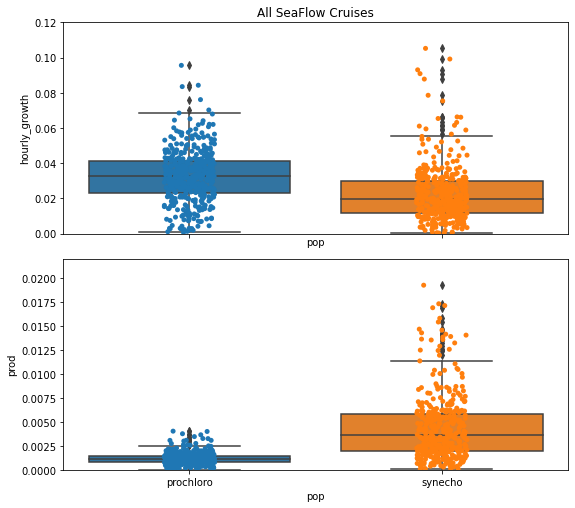

In [40]:
all_rates_df=pd.concat(all_rates)
# toss out some outliers
all_rates_df=all_rates_df.loc[all_rates_df['prod']<0.04]
title='All SeaFlow Cruises'
rates_box_plot(all_rates_df, title)

In [143]:
# create temp bins
def custom_round(x, base=5):
    return int(base * round(float(x)/base))

rates_temp=all_rates_df.loc[all_rates_df['temp'].notnull()]
rates_temp['round_temp']=rates_temp['temp'].apply(lambda x: custom_round(x, base=2))

# calculate top 20% per bin
rates_temp['top_growth']='Below'
rates_temp.loc[rates_temp['hourly_growth'] >= rates_temp.groupby(['pop',
                                                              'round_temp'])['hourly_growth'].transform('quantile',
                                                                                                        0.8),
              'top_growth']='Above'
# do same for productivity
rates_temp['top_prod']='Below'
rates_temp.loc[rates_temp['prod'] >= rates_temp.groupby(['pop',
                                                              'round_temp'])['prod'].transform('quantile',
                                                                                                        0.8),
              'top_prod']='Above'

px.scatter(rates_temp, x='temp',y='prod',facet_row='pop',color='top_prod')

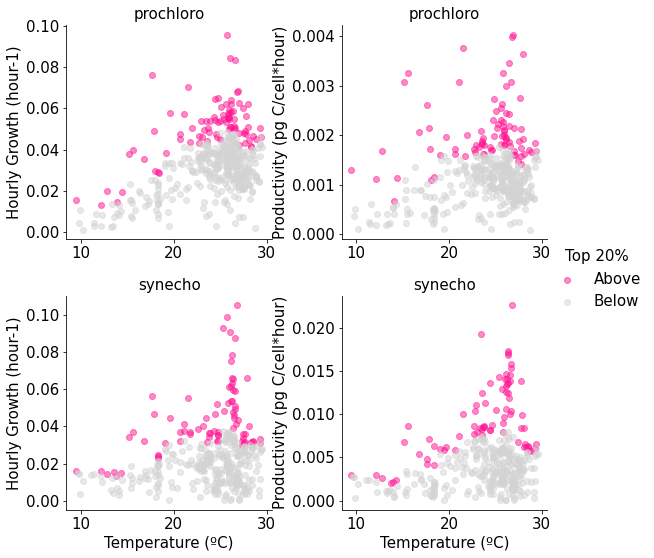

In [161]:
# melt for hourly and productivity values
melt_dat = pd.melt(rates_temp, id_vars=['cruise_day','pop','cruise','temp','lat'], 
               value_vars=['hourly_growth', 'prod'],
    var_name='var', value_name='val')
# melt for the top hourly vals each
melt2=pd.melt(rates_temp, id_vars=['cruise_day','pop','cruise','temp','lat'], 
               value_vars=['top_growth', 'top_prod'],
    var_name='top_rate', value_name='Top 20%')

id_vars=['cruise_day','pop','cruise','temp','lat']
df1=melt_dat.set_index(['cruise_day','pop','cruise','temp','lat', 
                    melt_dat.groupby(id_vars).cumcount()])
df2=melt2.set_index(['cruise_day','pop','cruise','temp','lat', 
                         melt2.groupby(id_vars).cumcount()])


df3=(pd.concat([df1, df2],axis=1)
         .sort_index(level=2)
         .reset_index(level=2, drop=True)
         .reset_index())


fig = sns.lmplot(
data=df3, x="temp", y="val", row="pop", col='var', palette=["deeppink","lightgrey"],
    height=4, sharey=False, sharex=False, hue='Top 20%', fit_reg=False,scatter_kws={'alpha':0.5})
# fig.set(ylim=(0, 0.12))
# set labels
fig.axes[1,1].set_xlabel('Temperature (ºC)')
fig.axes[1,0].set_xlabel('Temperature (ºC)')
fig.axes[0,0].set_ylabel('Hourly Growth (hour-1)')
fig.axes[0,1].set_ylabel('Productivity (pg C/cell*hour)')
fig.axes[1,0].set_ylabel('Hourly Growth (hour-1)')
fig.axes[1,1].set_ylabel('Productivity (pg C/cell*hour)')
[plt.setp(ax.texts, text="") for ax in fig.axes.flat] 
fig.set_titles('{row_name}')
plt.rcParams.update({'font.size':15})

In [129]:
# pop_names=np.repeat('prochloro',len(pro_trend)).tolist()
# pop_names.extend(np.repeat('synecho',len(syn_trend)))
# trends=np.concatenate([pro_trend,syn_trend]).ravel()
# len(pop_names)